# Approach: Decision Tree

## Setup

In [1]:
import pandas as pd
from sklearn import tree

In [2]:
# Load the files
existing_customers = pd.read_excel('data/existing-customers.xlsx')
potential_customers = pd.read_excel('data/potential-customers.xlsx')

/Users/tobiaswilfert/Documents/University/DM/data-mining-assignments/venv/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/Users/tobiaswilfert/Documents/University/DM/data-mining-assignments/venv/lib/python3.10/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
# Define the score metric
def ROI(recall, amount):
    return amount * (88*recall - 25.5*(1-recall))

## Premise

At the heart this assignment is a binary classification problem namely we want to decide wether a given person makes more than 50k, since these people are more likely to respond to our outreach (10% vs 5%) and offer a higher Profit (+980 vs -310). This classification can then be used to decide which person to mail, given that mailing cost 10 per person.  

The goal of this exercise is to maximize the return on investment.

### Observations
- The actual ROI for a person with 50K+ income is 980(avg. profit) * 0.1(since only 10% likely hood of accepting) - 10 (cost of promotional package) = 88
- The actual ROI for a person with 50k- income is -310(avg. profit) * 0.05(since only 5% likely hood of accepting) - 10 (cost of promotional package) = -25,5
- The upside of getting a person write is much higher than the downside of getting a person wrong. More precisely even a 33% accuracy would still allow us to make 11,955 profit.
- Furthermore, we can see that our general ROI is given by: `y * (88*x - 25,5*(1-x))` where `y` is the number of packages we send and `x` the percentage of receivers with a 50k+ income (i.e the Recall of our classifier).
- Looking at this formula it becomes clear that our ROI is dependent on the Recall and the total number or Receivers.
- Looking at this it becomes clear that we should send the package to all people with a chance of more than  25,5/88 of making more than 50k

## Data exploration
***NOTE:*** A lot of data exploration has been done in the exploration notebook this sections just repeats the most relevant findings.

In [7]:
# Features
print(f"The features of the two datasets:")
print(f"- existing_customers: {list(existing_customers)}")
print(f"- potential_customers: {list(potential_customers)}")

The features of the two datasets:
- existing_customers: ['RowID', 'age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'class']
- potential_customers: ['RowID', 'age', 'workclass', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']


In [8]:
# Missing values
print(f"The number of NaN entries in:")
print(f"- existing_customers: {existing_customers.isnull().sum().sum()}")
print(f"- potential_customers: {potential_customers.isnull().sum().sum()}")

The number of NaN entries in:
- existing_customers: 4262
- potential_customers: 2203


In [9]:
# How many rows are affected
print(f"{existing_customers[existing_customers.isnull().any(axis=1)].shape[0] / existing_customers.shape[0]*100}% of rows contain NaN in existing_customers.")
print(f"{potential_customers[potential_customers.isnull().any(axis=1)].shape[0] / potential_customers.shape[0]*100}% of rows contain NaN in potential_customers.")

7.367709836921471% of rows contain NaN in existing_customers.
7.499539340335361% of rows contain NaN in potential_customers.


In [10]:
# Feature distributions existing_customers
for feature in existing_customers.columns[1:]:
    print(feature)
    print(existing_customers[feature].value_counts())

age
36    898
31    888
34    886
23    877
35    876
     ... 
83      6
88      3
85      3
86      1
87      1
Name: age, Length: 73, dtype: int64
workclass
Private             22696
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64
education
HS-grad         10501
Some-college     7291
Bachelors        5355
Masters          1723
Assoc-voc        1382
11th             1175
Assoc-acdm       1067
10th              933
7th-8th           646
Prof-school       576
9th               514
12th              433
Doctorate         413
5th-6th           333
1st-4th           168
Preschool          51
Name: education, dtype: int64
education-num
9     10501
10     7291
13     5355
14     1723
11     1382
7      1175
12     1067
6       933
4       646
15      576
5       514
8       433
16      413
3       333
2       168
1        51
Name

In [11]:
# Feature distributions existing_customers
for feature in potential_customers.columns[1:]:
    print(feature)
    print(potential_customers[feature].value_counts())

age
35    461
33    460
23    452
36    450
31    437
     ... 
84      3
88      3
85      2
89      2
87      2
Name: age, Length: 73, dtype: int64
workclass
Private             11210
Self-emp-not-inc     1321
Local-gov            1043
State-gov             683
Self-emp-inc          579
Federal-gov           472
Without-pay             7
Never-worked            3
Name: workclass, dtype: int64
education
HS-grad         5283
Some-college    3587
Bachelors       2670
Masters          934
Assoc-voc        679
11th             637
Assoc-acdm       534
10th             456
7th-8th          309
Prof-school      258
9th              242
12th             224
Doctorate        181
5th-6th          176
1st-4th           79
Preschool         32
Name: education, dtype: int64
education-num
9     5283
10    3587
13    2670
14     934
11     679
7      637
12     534
6      456
4      309
15     258
5      242
8      224
16     181
3      176
2       79
1       32
Name: education-num, dtype: int64
ma

### Observations
- The data is heavily skewed to White Males that where born in the United-States.
- 24% of our current customers are in the 50k+ group.
- Both dataset appear to be equally skewed, i.e. no imbalance.

## Notes on Preprocessing & Feature selection
- As we have noted above around 7% entries in both datasets are affected by missing values. This needs to be mitigated, since SKlearn trees can't handle missing values.
- SKlearn trees can also not deal with categorical data, however as we have seen 8 of the 13 features are categorical so they need to be dealt with.
- We have seen some features are extremely poorly distributed such as 'native-country', so some feature selection might be interesting.
- We need a to split the data into a training, test and verifying set.

## Approach 1.All features ignore NaNs, GINI with limited depth, rest is default

### Preprocessing & Feature selection

In [12]:

from sklearn.model_selection import train_test_split

"""Most basic approach:
- All features
- NaN values are converted to all 0 when Categorical is Converted to Nominal + the conversion happens by introducing more dimensions
- Standard ratio is used for the splits
"""
def preprocessing_and_feature_selection(
    train_ratio = 0.70,
    validation_ratio = 0.15,
    test_ratio = 0.15,
):
    # Do the feature selection
    data_x = existing_customers[["age", "workclass", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country"]]
    data_y = existing_customers[["class"]]

    # Deal with the NaN entries
    # - Ignore them for now

    # Do the conversion from categorical to nominal
    data_x = pd.get_dummies(data_x)
    data_y = pd.get_dummies(data_y, drop_first=True) 

    # Split the data into test, training and validation
    x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=1 - train_ratio)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

    return x_train, x_val, x_test, y_train, y_val, y_test


### Training and Hyper parameter tweaking

In [15]:
from sklearn import metrics 

# Base line
x_train, x_val, x_test, y_train, y_val, y_test = preprocessing_and_feature_selection()
base_clf = tree.DecisionTreeClassifier()
base_clf = base_clf.fit(x_train,y_train)
y_pred = base_clf.predict(x_test)

# Output the Recall, Number of packages send and ROI
recall = metrics.recall_score(y_test, y_pred)
amount = y_pred.sum()
print(f"Recall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")
print(base_clf.get_depth())

Recall= 0.6022433132010354	Amount= 1164	 ROI=49882.77308024159
48


In [73]:
x_train, x_val, x_test, y_train, y_val, y_test = preprocessing_and_feature_selection()

In [111]:
def base():
    best_clf = None
    best_roi = 0

    # Check the accuracy at different depths
    for depth in range(1,49):
        clf = tree.DecisionTreeClassifier(max_depth=depth)
        clf = clf.fit(x_train,y_train)
        y_pred = clf.predict(x_test)

        recall = metrics.recall_score(y_test, y_pred)
        amount = y_pred.sum()

        if best_roi < ROI(recall, amount):
            print(f"Depth: {depth}\tRecall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")
            best_roi = ROI(recall, amount)
            best_clf = clf
    return best_clf

best_clf = base()

Depth: 2	Recall= 0.4428450465707028	Amount= 720	 ROI=17829.29720575783
Depth: 3	Recall= 0.5156646909398814	Amount= 805	 ROI=26587.493649449618
Depth: 4	Recall= 0.5182049110922947	Amount= 813	 ROI=27086.117273497042
Depth: 6	Recall= 0.5283657917019475	Amount= 794	 ROI=27368.79678238781
Depth: 7	Recall= 0.5325994919559696	Amount= 790	 ROI=27610.53344623201
Depth: 8	Recall= 0.5469940728196444	Amount= 812	 ROI=29706.067739204067
Depth: 9	Recall= 0.6706181202370872	Amount= 1127	 ROI=57043.28154106689
Depth: 11	Recall= 0.6909398814563928	Amount= 1196	 ROI=63294.3251481795


In [112]:
# Now lets get the final measure using the verification
y_pred = best_clf.predict(x_val)
recall = metrics.recall_score(y_val, y_pred)
amount = y_pred.sum()
print(f"Depth: {best_clf.get_depth()}\tRecall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")

Depth: 11	Recall= 0.6781818181818182	Amount= 1127	 ROI=58010.78818181819


### Prediction

In [113]:
# Using the above recall value we can now make a prediction for the real thing
deploy_x = potential_customers[["age", "workclass", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country"]]
deploy_x = pd.get_dummies(deploy_x)
# Append the native-country_Holand-Netherlands to fix
deploy_x.insert(list(x_train).index('native-country_Holand-Netherlands'), 'native-country_Holand-Netherlands', 0)
y_pred = best_clf.predict(deploy_x)
amount = y_pred.sum()

print(f"Depth: {best_clf.get_depth()}\tRecall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")


Depth: 11	Recall= 0.6781818181818182	Amount= 3825	 ROI=196886.65909090912


In [114]:
# Get the actual RowIDs
print(list(potential_customers[y_pred.astype(bool)]['RowID']))

['Row3', 'Row10', 'Row11', 'Row15', 'Row17', 'Row19', 'Row20', 'Row25', 'Row30', 'Row36', 'Row40', 'Row41', 'Row47', 'Row53', 'Row57', 'Row58', 'Row66', 'Row70', 'Row71', 'Row74', 'Row80', 'Row83', 'Row89', 'Row92', 'Row114', 'Row126', 'Row128', 'Row129', 'Row130', 'Row133', 'Row140', 'Row142', 'Row143', 'Row148', 'Row154', 'Row164', 'Row166', 'Row170', 'Row175', 'Row177', 'Row179', 'Row181', 'Row190', 'Row197', 'Row200', 'Row204', 'Row205', 'Row208', 'Row213', 'Row220', 'Row224', 'Row225', 'Row226', 'Row227', 'Row229', 'Row231', 'Row232', 'Row233', 'Row236', 'Row260', 'Row272', 'Row278', 'Row284', 'Row287', 'Row288', 'Row290', 'Row298', 'Row300', 'Row308', 'Row310', 'Row318', 'Row321', 'Row325', 'Row329', 'Row334', 'Row339', 'Row343', 'Row344', 'Row346', 'Row347', 'Row355', 'Row357', 'Row365', 'Row366', 'Row368', 'Row373', 'Row375', 'Row376', 'Row388', 'Row389', 'Row396', 'Row398', 'Row399', 'Row409', 'Row417', 'Row418', 'Row435', 'Row436', 'Row439', 'Row445', 'Row446', 'Row452', 'Row

## Approach 1.2 Greedy (Use full potential of ROI)

In [98]:
def base():
    best_clf = None
    best_roi = 0

    # Check the accuracy at different depths
    for depth in range(1,49):
        clf = tree.DecisionTreeClassifier(max_depth=depth)
        clf = clf.fit(x_train,y_train)
        y_pred = pd.DataFrame(clf.predict_proba(x_test))
        y_pred = y_pred.iloc[:, 1] > (25.5/88)

        recall = metrics.recall_score(y_test, y_pred)
        amount = y_pred.sum()

        print(f"Depth: {depth}\tRecall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")
        if best_roi < ROI(recall, amount):
            best_roi = ROI(recall, amount)
            best_clf = clf
    return best_clf

best_clf = base()

Depth: 1	Recall= 0.8535139712108383	Amount= 2286	 ROI=163160.58848433534
Depth: 2	Recall= 0.890770533446232	Amount= 2332	 ROI=176304.92633361556
Depth: 3	Recall= 0.890770533446232	Amount= 2330	 ROI=176153.72142252326
Depth: 4	Recall= 0.8746824724809483	Amount= 2100	 ROI=154930.56731583402
Depth: 5	Recall= 0.8441998306519899	Amount= 1805	 ROI=126921.60880609653
Depth: 6	Recall= 0.8103302286198137	Amount= 1676	 ROI=111407.87806943269
Depth: 7	Recall= 0.8077900084674005	Amount= 1606	 ROI=106291.77053344621
Depth: 8	Recall= 0.8450465707027942	Amount= 1761	 ROI=123996.91574936494
Depth: 9	Recall= 0.8179508890770534	Amount= 1633	 ROI=109962.016511431
Depth: 10	Recall= 0.8128704487722269	Amount= 1622	 ROI=108286.01100762065
Depth: 11	Recall= 0.8145639288738358	Amount= 1641	 ROI=109869.88272650297
Depth: 12	Recall= 0.7510584250635055	Amount= 1447	 ROI=86451.20491109228
Depth: 13	Recall= 0.8145639288738358	Amount= 1666	 ROI=111543.70787468247
Depth: 14	Recall= 0.7883149872988993	Amount= 1605	 R

In [96]:
# Now lets get the final measure using the verification
y_pred = pd.DataFrame(best_clf.predict_proba(x_val))
y_pred = y_pred.iloc[:, 1] > (25.5/88)
recall = metrics.recall_score(y_val, y_pred)
amount = y_pred.sum()
print(f"Depth: {best_clf.get_depth()}\tRecall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")

Depth: 2	Recall= 0.89	Amount= 2254	 ROI=170210.81000000003


### Prediction

In [108]:
# Using the above recall value we can now make a prediction for the real thing
deploy_x = potential_customers[["age", "workclass", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week", "native-country"]]
deploy_x = pd.get_dummies(deploy_x)
# Append the native-country_Holand-Netherlands to fix
deploy_x.insert(list(x_train).index('native-country_Holand-Netherlands'), 'native-country_Holand-Netherlands', 0)
y_pred = pd.DataFrame(best_clf.predict_proba(deploy_x))
y_pred = y_pred.iloc[:, 1] > (25.5/88)
amount = y_pred.sum()

print(f"Depth: {best_clf.get_depth()}\tRecall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")


Depth: 2	Recall= 0.89	Amount= 7555	 ROI=570515.8250000001


In [109]:
# Get the actual RowIDs
print(list(potential_customers[y_pred.astype(bool)]['RowID']))

['Row1', 'Row2', 'Row3', 'Row7', 'Row9', 'Row10', 'Row11', 'Row13', 'Row14', 'Row15', 'Row17', 'Row19', 'Row20', 'Row24', 'Row25', 'Row28', 'Row30', 'Row33', 'Row35', 'Row36', 'Row40', 'Row41', 'Row42', 'Row43', 'Row45', 'Row46', 'Row47', 'Row53', 'Row56', 'Row57', 'Row58', 'Row59', 'Row66', 'Row69', 'Row70', 'Row71', 'Row72', 'Row74', 'Row76', 'Row77', 'Row78', 'Row80', 'Row83', 'Row84', 'Row87', 'Row89', 'Row92', 'Row97', 'Row98', 'Row100', 'Row106', 'Row111', 'Row112', 'Row114', 'Row116', 'Row126', 'Row128', 'Row129', 'Row130', 'Row133', 'Row134', 'Row136', 'Row137', 'Row138', 'Row139', 'Row140', 'Row142', 'Row143', 'Row147', 'Row148', 'Row151', 'Row152', 'Row154', 'Row160', 'Row161', 'Row162', 'Row164', 'Row165', 'Row166', 'Row167', 'Row170', 'Row173', 'Row175', 'Row176', 'Row177', 'Row178', 'Row179', 'Row181', 'Row182', 'Row185', 'Row190', 'Row197', 'Row199', 'Row200', 'Row201', 'Row204', 'Row205', 'Row206', 'Row207', 'Row208', 'Row209', 'Row213', 'Row215', 'Row220', 'Row223', 'Ro

### Analysis (See how this 89% is happening)

[Text(0.5, 0.8333333333333334, 'marital-status_Married-civ-spouse <= 0.5\ngini = 0.369\nsamples = 22792\nvalue = [17232, 5560]\nclass = <=50k'),
 Text(0.25, 0.5, 'capital-gain <= 7073.5\ngini = 0.123\nsamples = 12310\nvalue = [11498, 812]\nclass = <=50k'),
 Text(0.125, 0.16666666666666666, 'gini = 0.094\nsamples = 12091\nvalue = [11492, 599]\nclass = <=50k'),
 Text(0.375, 0.16666666666666666, 'gini = 0.053\nsamples = 219\nvalue = [6, 213]\nclass = >50k'),
 Text(0.75, 0.5, 'education-num <= 12.5\ngini = 0.496\nsamples = 10482\nvalue = [5734, 4748]\nclass = <=50k'),
 Text(0.625, 0.16666666666666666, 'gini = 0.446\nsamples = 7333\nvalue = [4867, 2466]\nclass = <=50k'),
 Text(0.875, 0.16666666666666666, 'gini = 0.399\nsamples = 3149\nvalue = [867, 2282]\nclass = >50k')]

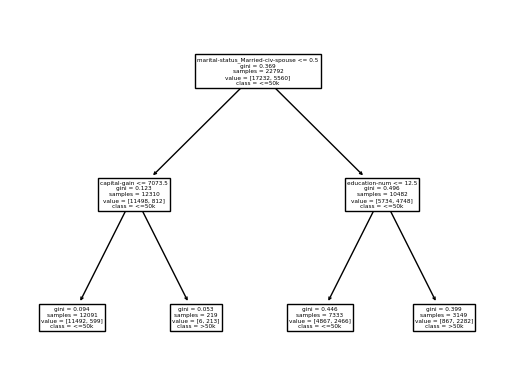

In [107]:
tree.plot_tree(best_clf,  feature_names=x_train.columns, class_names=['<=50k', '>50k'])

### Conclusion
- The greedy approach as expected seems to produce a better value.
- 89% Seems like over-fitting so trying less features might be interesting???
- The native_country feature introduces a lot of rows when converted + requires manual insertion of columns into the dataset, since this is also a very unbalanced feature it might be interesting to ignore for the next approach.

## Approach 2: Fill in missing values
Idea is to fill in the missing values with the most common occurrence for categorical data and the mean value for the rest.

In [20]:
# Closer inspection into which columns actually have missing values
existing_customers.isnull().sum()


RowID                0
age                  0
workclass         1836
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     583
class                0
dtype: int64

In [21]:
# Closer inspection into which columns actually have missing values
potential_customers.isnull().sum()


RowID               0
age                 0
workclass         963
education           0
education-num       0
marital-status      0
occupation        966
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    274
dtype: int64

### Conclusion 
Only columns with categorical data have missing values so need to find a way to handle this, so lets try substituting in the most common occurrence and making sure to only do it after the splitting of the dataset as to avoid information from the test set to keep into the training and validation set.

In [61]:
from sklearn.model_selection import train_test_split

def preprocessing_and_feature_selection_with_fillna(
    train_ratio = 0.70,
    validation_ratio = 0.15,
    test_ratio = 0.15,
):
    # Do the feature selection
    data_x = existing_customers[["age", "workclass", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week"]]
    data_y = existing_customers[["class"]]
    
    # Split the data into test, training and validation
    x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=1 - train_ratio)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

    # Deal with the NaN entries - fill with the most common occurrences 
    # Needs to be done before the dummies but after the split :/ -> This as expected causes issues since now tows needs to be inserted
    x_train = x_train.fillna(x_train.mode().iloc[0])
    x_test = x_test.fillna(x_test.mode().iloc[0])
    x_val = x_val.fillna(x_val.mode().iloc[0])

    # Do the conversion from categorical to nominal
    x_train = pd.get_dummies(x_train)
    x_test = pd.get_dummies(x_test)
    x_val = pd.get_dummies(x_val)
    y_train = pd.get_dummies(y_train, drop_first=True)
    y_test = pd.get_dummies(y_test, drop_first=True) 
    y_val = pd.get_dummies(y_val, drop_first=True) 

    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = preprocessing_and_feature_selection_with_fillna()

x_train.isnull().sum()

age               0
education-num     0
capital-gain      0
capital-loss      0
hours-per-week    0
                 ..
race_Black        0
race_Other        0
race_White        0
sex_Female        0
sex_Male          0
Length: 63, dtype: int64

In [62]:
# Check if there are issues caused by using the more correct approach?
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)

# Fix the issues
for col in set(x_train.columns).difference(set(x_test.columns)):
    x_test.insert(list(x_train).index(col), col, 0)

for col in set(x_train.columns).difference(set(x_val.columns)):
    x_val.insert(list(x_train).index(col), col, 0)

print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(x_train.columns == x_test.columns)
print(x_train.columns)
print(x_test.columns)

# Doesn't work so give up for now :/

(22792, 63)
(4885, 63)
(4884, 62)
(22792, 63)
(4885, 63)
(4884, 63)
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True]
Index(['age', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass_Federal-gov', 'workclass_Local-gov',
       'workclass_Never-worked', 'workclass_Private', 'workclass_Self-emp-inc',
       'workclass_Self-emp-not-inc', 'workclass_State-gov',
       'workclass_Without-pay', 'education_10th', 'education_11th',
       'education_12th', 'education_1st-4th', 'education_5th-6th',
       'education_7th-8th', 'education_9th', 'education_Assoc-acdm',
       'education_Assoc-voc', 'education_Bachelors', 'education_Doc

In [63]:
from sklearn import metrics 

# Base line
base_clf = tree.DecisionTreeClassifier()
base_clf = base_clf.fit(x_train,y_train)
y_pred = base_clf.predict(x_test)

# Output the Recall, Number of packages send and ROI
recall = metrics.recall_score(y_test, y_pred)
amount = y_pred.sum()
print(f"Recall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")
print(base_clf.get_depth())

# Recall= 0.6022433132010354	Amount= 1164	 ROI=49882.77308024159
# 48

Recall= 0.6030405405405406	Amount= 1127	 ROI=48399.12922297297
43


### Observation:
- Lower base line than before even though the accuracy is better, so lets do some more tests and see how it goes.
- Since the greedy approach did better (which also makes intuitive sense) we shall only apply that approach here

In [64]:
def base():
    best_clf = None
    best_roi = 0

    # Check the accuracy at different depths
    for depth in range(1,49):
        clf = tree.DecisionTreeClassifier(max_depth=depth)
        clf = clf.fit(x_train,y_train)
        y_pred = pd.DataFrame(clf.predict_proba(x_test))
        y_pred = y_pred.iloc[:, 1] > (25.5/88)

        recall = metrics.recall_score(y_test, y_pred)
        amount = y_pred.sum()

        print(f"Depth: {depth}\tRecall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")
        if best_roi < ROI(recall, amount):
            best_roi = ROI(recall, amount)
            best_clf = clf
    return best_clf

best_clf = base()

Depth: 1	Recall= 0.8589527027027027	Amount= 2248	 ROI=161836.0641891892
Depth: 2	Recall= 0.8986486486486487	Amount= 2298	 ROI=175789.2364864865
Depth: 3	Recall= 0.8986486486486487	Amount= 2298	 ROI=175789.2364864865
Depth: 4	Recall= 0.8758445945945946	Amount= 2048	 ROI=151364.32432432432
Depth: 5	Recall= 0.8217905405405406	Amount= 1740	 ROI=117925.41385135136
Depth: 6	Recall= 0.8158783783783784	Amount= 1695	 ROI=113738.22212837839
Depth: 7	Recall= 0.8074324324324325	Amount= 1578	 ROI=104374.57094594596
Depth: 8	Recall= 0.8201013513513513	Amount= 1630	 ROI=110157.85050675675
Depth: 9	Recall= 0.8344594594594594	Amount= 1677	 ROI=116067.09628378377
Depth: 10	Recall= 0.8462837837837838	Amount= 1740	 ROI=122762.58445945945
Depth: 11	Recall= 0.7778716216216216	Amount= 1474	 ROI=92550.14442567567
Depth: 12	Recall= 0.7668918918918919	Amount= 1451	 ROI=89297.77533783783
Depth: 13	Recall= 0.754222972972973	Amount= 1440	 ROI=86550.20270270272
Depth: 14	Recall= 0.754222972972973	Amount= 1442	 ROI=

In [65]:
# Now lets get the final measure using the verification
y_pred = pd.DataFrame(best_clf.predict_proba(x_val))
y_pred = y_pred.iloc[:, 1] > (25.5/88)
recall = metrics.recall_score(y_val, y_pred)
amount = y_pred.sum()
print(f"Depth: {best_clf.get_depth()}\tRecall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")

# Previous: Depth: 2	Recall= 0.89	Amount= 2254	 ROI=170210.81000000003  -> So slightly better ROI 

Depth: 2	Recall= 0.8903878583473862	Amount= 2328	 ROI=175901.40303541315


### Prediction

In [67]:
# Using the above recall value we can now make a prediction for the real thing
deploy_x = potential_customers[["age", "workclass", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week"]]
deploy_x = pd.get_dummies(deploy_x)

y_pred = pd.DataFrame(best_clf.predict_proba(deploy_x))
y_pred = y_pred.iloc[:, 1] > (25.5/88)
amount = y_pred.sum()

print(f"Depth: {best_clf.get_depth()}\tRecall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")

Depth: 2	Recall= 0.8903878583473862	Amount= 7555	 ROI=570848.410623946


In [68]:
# Get the actual RowIDs
print(list(potential_customers[y_pred.astype(bool)]['RowID']))

['Row1', 'Row2', 'Row3', 'Row7', 'Row9', 'Row10', 'Row11', 'Row13', 'Row14', 'Row15', 'Row17', 'Row19', 'Row20', 'Row24', 'Row25', 'Row28', 'Row30', 'Row33', 'Row35', 'Row36', 'Row40', 'Row41', 'Row42', 'Row43', 'Row45', 'Row46', 'Row47', 'Row53', 'Row56', 'Row57', 'Row58', 'Row59', 'Row66', 'Row69', 'Row70', 'Row71', 'Row72', 'Row74', 'Row76', 'Row77', 'Row78', 'Row80', 'Row83', 'Row84', 'Row87', 'Row89', 'Row92', 'Row97', 'Row98', 'Row100', 'Row106', 'Row111', 'Row112', 'Row114', 'Row116', 'Row126', 'Row128', 'Row129', 'Row130', 'Row133', 'Row134', 'Row136', 'Row137', 'Row138', 'Row139', 'Row140', 'Row142', 'Row143', 'Row147', 'Row148', 'Row151', 'Row152', 'Row154', 'Row160', 'Row161', 'Row162', 'Row164', 'Row165', 'Row166', 'Row167', 'Row170', 'Row173', 'Row175', 'Row176', 'Row177', 'Row178', 'Row179', 'Row181', 'Row182', 'Row185', 'Row190', 'Row197', 'Row199', 'Row200', 'Row201', 'Row204', 'Row205', 'Row206', 'Row207', 'Row208', 'Row209', 'Row213', 'Row215', 'Row220', 'Row223', 'Ro

In [70]:
# Since the prediction didn't work fill in the missing values for the prod set as well

# Using the above recall value we can now make a prediction for the real thing
deploy_x = potential_customers[["age", "workclass", "education", "education-num", "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week"]]
deploy_x.fillna(deploy_x.mode().iloc[0])
deploy_x = pd.get_dummies(deploy_x)

y_pred = pd.DataFrame(best_clf.predict_proba(deploy_x))
y_pred = y_pred.iloc[:, 1] > (25.5/88)
amount = y_pred.sum()

print(f"Depth: {best_clf.get_depth()}\tRecall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")

Depth: 2	Recall= 0.8903878583473862	Amount= 7555	 ROI=570848.410623946


### Conclusion
- Minor improvement in recall does not translate to a real increase in the predicted ROI.

## Approach 3: More selected features
We have seen that 3 features hae incomplete data both in the training and test set as such we will ignore these features here and see how that will effect the outcome.

In [71]:
def preprocessing_and_feature_selection_less_features(
    train_ratio = 0.70,
    validation_ratio = 0.15,
    test_ratio = 0.15,
):
    # Do the feature selection
    data_x = existing_customers[["age", "education", "education-num", "marital-status", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week"]]
    data_y = existing_customers[["class"]]

    # Deal with the NaN entries
    # - Ignore them for now

    # Do the conversion from categorical to nominal
    data_x = pd.get_dummies(data_x)
    data_y = pd.get_dummies(data_y, drop_first=True) 

    # Split the data into test, training and validation
    x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=1 - train_ratio)
    x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

    return x_train, x_val, x_test, y_train, y_val, y_test

x_train, x_val, x_test, y_train, y_val, y_test = preprocessing_and_feature_selection_less_features()

In [72]:
from sklearn import metrics 

# Base line
base_clf = tree.DecisionTreeClassifier()
base_clf = base_clf.fit(x_train,y_train)
y_pred = base_clf.predict(x_test)

# Output the Recall, Number of packages send and ROI
recall = metrics.recall_score(y_test, y_pred)
amount = y_pred.sum()
print(f"Recall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")
print(base_clf.get_depth())

# Recall= 0.6022433132010354	Amount= 1164	 ROI=49882.77308024159
# 48
# Recall= 0.6030405405405406	Amount= 1127	 ROI=48399.12922297297
# 43

# Worse bas line but see hot it unfolds

Recall= 0.5785407725321888	Amount= 1053	 ROI=42293.08969957081
37


In [73]:
def base():
    best_clf = None
    best_roi = 0

    # Check the accuracy at different depths
    for depth in range(1,49):
        clf = tree.DecisionTreeClassifier(max_depth=depth)
        clf = clf.fit(x_train,y_train)
        y_pred = pd.DataFrame(clf.predict_proba(x_test))
        y_pred = y_pred.iloc[:, 1] > (25.5/88)

        recall = metrics.recall_score(y_test, y_pred)
        amount = y_pred.sum()

        print(f"Depth: {depth}\tRecall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")
        if best_roi < ROI(recall, amount):
            best_roi = ROI(recall, amount)
            best_clf = clf
    return best_clf

best_clf = base()

Depth: 1	Recall= 0.8592274678111588	Amount= 2187	 ROI=157512.808583691
Depth: 2	Recall= 0.8901287553648068	Amount= 2225	 ROI=168053.3905579399
Depth: 3	Recall= 0.8901287553648068	Amount= 2223	 ROI=167902.3313304721
Depth: 4	Recall= 0.8969957081545065	Amount= 2109	 ROI=160935.70815450643
Depth: 5	Recall= 0.8257510729613734	Amount= 1655	 ROI=112908.64592274677
Depth: 6	Recall= 0.8283261802575107	Amount= 1651	 ROI=113118.30042918453
Depth: 7	Recall= 0.8180257510729614	Amount= 1555	 ROI=104722.90987124463
Depth: 8	Recall= 0.8291845493562232	Amount= 1588	 ROI=108956.56480686697
Depth: 9	Recall= 0.8523605150214593	Amount= 1692	 ROI=120543.01802575107
Depth: 10	Recall= 0.8248927038626609	Amount= 1593	 ROI=108523.63776824034
Depth: 11	Recall= 0.8334763948497854	Amount= 1618	 ROI=111803.10557939915
Depth: 12	Recall= 0.8274678111587983	Amount= 1619	 ROI=110768.08884120172
Depth: 13	Recall= 0.8300429184549356	Amount= 1632	 ROI=112134.50987124463
Depth: 14	Recall= 0.8206008583690987	Amount= 1637	 

In [74]:
# Now lets get the final measure using the verification
y_pred = pd.DataFrame(best_clf.predict_proba(x_val))
y_pred = y_pred.iloc[:, 1] > (25.5/88)
recall = metrics.recall_score(y_val, y_pred)
amount = y_pred.sum()
print(f"Depth: {best_clf.get_depth()}\tRecall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")

# Previous: Depth: 2	Recall= 0.89	Amount= 2254	 ROI=170210.81000000003  -> So slightly better ROI 
# Depth: 2	Recall= 0.8903878583473862	Amount= 2328	 ROI=175901.40303541315 -> Slightly worse ROI

Depth: 2	Recall= 0.8875103391232424	Amount= 2303	 ROI=173260.27129859387


### Prediction

In [75]:
# Using the above recall value we can now make a prediction for the real thing
deploy_x = potential_customers[["age", "education", "education-num", "marital-status", "relationship", "race", "sex", "capital-gain", "capital-loss", "hours-per-week"]]
deploy_x = pd.get_dummies(deploy_x)

y_pred = pd.DataFrame(best_clf.predict_proba(deploy_x))
y_pred = y_pred.iloc[:, 1] > (25.5/88)
amount = y_pred.sum()

print(f"Depth: {best_clf.get_depth()}\tRecall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")

Depth: 2	Recall= 0.8875103391232424	Amount= 7555	 ROI=568380.9594706369


In [82]:
# Get the actual RowIDs
print(list(potential_customers[y_pred.astype(bool)]['RowID']))

['Row1', 'Row2', 'Row3', 'Row7', 'Row9', 'Row10', 'Row11', 'Row13', 'Row14', 'Row15', 'Row17', 'Row19', 'Row20', 'Row24', 'Row25', 'Row28', 'Row30', 'Row33', 'Row35', 'Row36', 'Row40', 'Row41', 'Row42', 'Row43', 'Row45', 'Row46', 'Row47', 'Row53', 'Row56', 'Row57', 'Row58', 'Row59', 'Row66', 'Row69', 'Row70', 'Row71', 'Row72', 'Row74', 'Row76', 'Row77', 'Row78', 'Row80', 'Row83', 'Row84', 'Row87', 'Row89', 'Row92', 'Row97', 'Row98', 'Row100', 'Row106', 'Row111', 'Row112', 'Row114', 'Row116', 'Row126', 'Row128', 'Row129', 'Row130', 'Row133', 'Row134', 'Row136', 'Row137', 'Row138', 'Row139', 'Row140', 'Row142', 'Row143', 'Row147', 'Row148', 'Row151', 'Row152', 'Row154', 'Row160', 'Row161', 'Row162', 'Row164', 'Row165', 'Row166', 'Row167', 'Row170', 'Row173', 'Row175', 'Row176', 'Row177', 'Row178', 'Row179', 'Row181', 'Row182', 'Row185', 'Row190', 'Row197', 'Row199', 'Row200', 'Row201', 'Row204', 'Row205', 'Row206', 'Row207', 'Row208', 'Row209', 'Row213', 'Row215', 'Row220', 'Row223', 'Ro

# Conclusion:
- A tree of height 2 while not the one will the lowest recall still has the highest predicted ROI due to the fact that it classifies more (potential) people that on average indeed seem to be promising.

[Text(0.5, 0.8333333333333334, 'marital-status_Married-civ-spouse <= 0.5\ngini = 0.365\nsamples = 22792\nvalue = [17325, 5467]\nclass = <=50k'),
 Text(0.25, 0.5, 'capital-gain <= 7073.5\ngini = 0.122\nsamples = 12258\nvalue = [11456, 802]\nclass = <=50k'),
 Text(0.125, 0.16666666666666666, 'gini = 0.093\nsamples = 12033\nvalue = [11448, 585]\nclass = <=50k'),
 Text(0.375, 0.16666666666666666, 'gini = 0.069\nsamples = 225\nvalue = [8, 217]\nclass = >50k'),
 Text(0.75, 0.5, 'education-num <= 12.5\ngini = 0.493\nsamples = 10534\nvalue = [5869, 4665]\nclass = <=50k'),
 Text(0.625, 0.16666666666666666, 'gini = 0.442\nsamples = 7413\nvalue = [4966, 2447]\nclass = <=50k'),
 Text(0.875, 0.16666666666666666, 'gini = 0.411\nsamples = 3121\nvalue = [903, 2218]\nclass = >50k')]

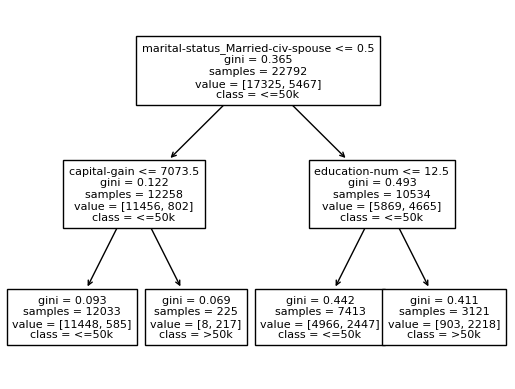

In [81]:
tree.plot_tree(best_clf,  feature_names=x_train.columns, class_names=['<=50k', '>50k'], fontsize=8)

In [83]:
print(f"Depth: {best_clf.get_depth()}\tRecall= {recall}\tAmount= {amount}\t ROI={ROI(recall, amount)}")

Depth: 2	Recall= 0.8875103391232424	Amount= 7555	 ROI=568380.9594706369


In [86]:
# Get the actual RowIDs

f = open("rows.txt", "x")
f.write("\n".join(list(potential_customers[y_pred.astype(bool)]['RowID'])))
f.close()